Downloading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
#Change the current working directory to the path of Google Cloud Drive
path="/content/drive/MyDrive/Task 0"
os.chdir(path)
os.listdir(path)

['archive.zip',
 'chest_xray',
 'label_distribution.png',
 'cnn_rmsprop.best.weight.hdf5']

In [ ]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

Importing the Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import ZeroPadding2D, SeparableConv2D
from keras import backend as K
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam ,SGD


import cv2
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.tools as tls
import collections
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,confusion_matrix,classification_report

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_data_dir = '/content/drive/MyDrive/Task 0/chest_xray/train'
validation_data_dir = '/content/drive/MyDrive/Task 0/chest_xray/val'
test_data_dir = '/content/drive/MyDrive/Task 0/chest_xray/test'

set up random seed to shuffle data

In [ ]:
os.environ['PYTHONHASHSEED'] = "0"
np.random.seed(1)
tf.random.set_seed(2)

/content/drive/MyDrive/Task 0/chest_xray/train/NORMAL


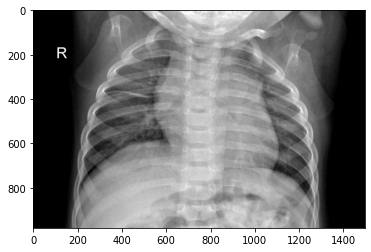

Original Image Array Size: (981, 1496)


In [ ]:
CATEGORIES = ["NORMAL", "PNEUMONIA"] 

for category in CATEGORIES:  # do normal and pneumonia
    
    path = os.path.join(train_data_dir,category)  # create path to normal and pneumonia
        
    print(path)
    for img in os.listdir(path):  # iterate over each image per normal and pneumonia
            
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
            
        plt.imshow(img_array, cmap='gray')  # graph it
            
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!
    
print("Original Image Array Size: {}".format(img_array.shape))

Downsizing the Images

(Left) - NORMAL  Vs (Right) - PNEUMONIA
---------------------------------------------------------------------------------------------------------------------


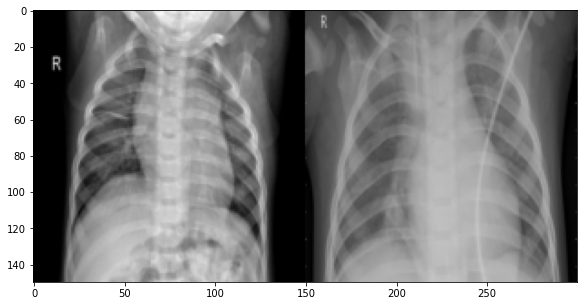

(Left) - NORMAL  Vs (Right) - PNEUMONIA
---------------------------------------------------------------------------------------------------------------------


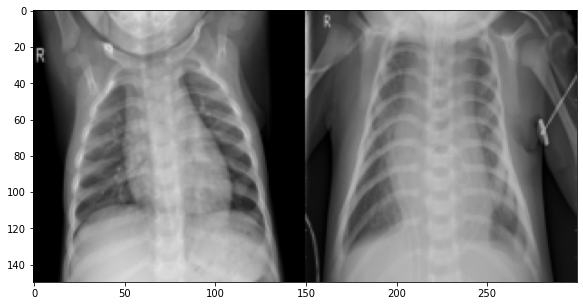

(Left) - NORMAL  Vs (Right) - PNEUMONIA
---------------------------------------------------------------------------------------------------------------------


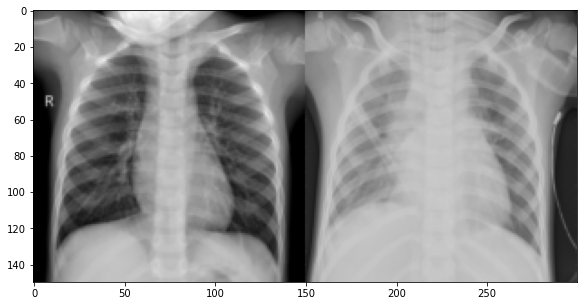

(Left) - NORMAL  Vs (Right) - PNEUMONIA
---------------------------------------------------------------------------------------------------------------------


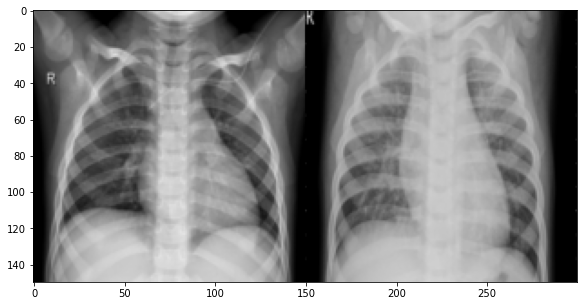

(Left) - NORMAL  Vs (Right) - PNEUMONIA
---------------------------------------------------------------------------------------------------------------------


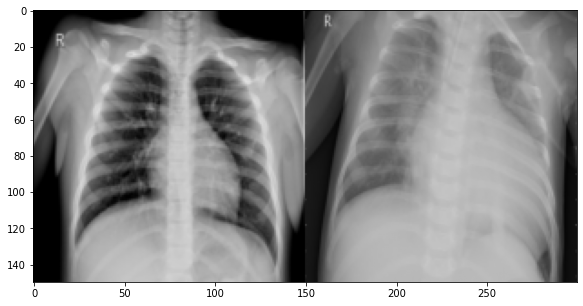

In [ ]:
Pimages = os.listdir(train_data_dir + "/PNEUMONIA")
Nimages = os.listdir(train_data_dir + "/NORMAL")
from skimage import transform
def plotter(i): # grab a pair of images from either label class
    imagep1 = cv2.imread(train_data_dir+"/PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(train_data_dir+"/NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - NORMAL  Vs (Right) - PNEUMONIA")
    print("---------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5): # return fives pairs of images
    plotter(i)

In [ ]:
train_data =[]
IMG_SIZE = 150

def create_data(directory,data): # method to create greyscale image data for processing 
    for category in CATEGORIES:  # do normal and pneumonia

        path = os.path.join(directory,category)  # create path to normal and pneumonia
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=normal 1=pneumonia

        for img in tqdm(os.listdir(path)):  # iterate over each image per normal and pneumonia
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                
                data.append([img_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))
            
create_data(train_data_dir,train_data)

100%|██████████| 3875/3875 [01:46<00:00, 36.34it/s] 


In [ ]:
y_train = [] # create training data set for plotting 

for features,label in train_data:
    y_train.append(label)

y_array = np.asarray(y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



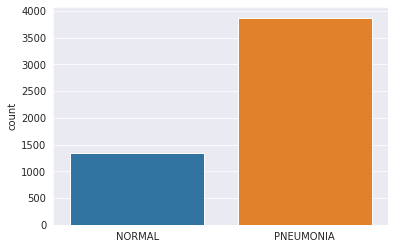

In [ ]:
sns.set_style("darkgrid") # plot training class distribution 
ax = sns.countplot(y_array)
ax.set_xticklabels(["NORMAL","PNEUMONIA"])

plt.savefig('label_distribution.png')

Image Augmentation

In [ ]:
# dimensions of our images.
img_width, img_height = 150, 150

In [ ]:
nb_train_samples = 5217
nb_validation_samples = 17
epochs = 20
batch_size = 16

In [ ]:
if K.image_data_format() == 'channels_first': # orient image input shape 
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)

In [ ]:
# this is the augmentation configuration we will use for training
gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_gen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
def cnn_model(): # this will be the general CNN structure
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    
    return model

model = cnn_model()

In [ ]:
model = cnn_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 activation_5 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_6 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                  

In [ ]:
train_batches = gen.flow_from_directory(train_data_dir,model.input_shape[1:3],
                                        color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16)

valid_batches = gen.flow_from_directory(validation_data_dir, model.input_shape[1:3],
                                        color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=16)

test_batches = test_gen.flow_from_directory(test_data_dir, model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=8)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


RMSProp CNN

In [ ]:
def cnn_model_rmsprop(): # this will be the general CNN structure
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    
    return model

In [ ]:
filepath = 'cnn_rmsprop.best.weight.hdf5' # create checkpoint and callback to save best CNN weights 
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=2, 
                              save_best_only=True, 
                              mode='min')
callbacks_list_rmsprop = [checkpoint]

In [ ]:
%%time
model = cnn_model_rmsprop() 

history_rmsprop = model.fit_generator(train_batches, class_weight={0:1.0, 1:0.4},
                                  steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=valid_batches,
                                  validation_steps=nb_validation_samples // batch_size, 
                                  callbacks=callbacks_list_rmsprop, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/20
326/326 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.7951
Epoch 1: val_loss improved from inf to 0.75313, saving model to cnn_rmsprop.best.weight.hdf5
326/326 [==============================] - 106s 280ms/step - loss: 0.2653 - accuracy: 0.7951 - val_loss: 0.7531 - val_accuracy: 0.6250
Epoch 2/20
326/326 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.8834
Epoch 2: val_loss did not improve from 0.75313
326/326 [==============================] - 76s 234ms/step - loss: 0.1660 - accuracy: 0.8834 - val_loss: 2.0197 - val_accuracy: 0.5625
Epoch 3/20
326/326 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.9107
Epoch 3: val_loss did not improve from 0.75313
326/326 [==============================] - 73s 225ms/step - loss: 0.1462 - accuracy: 0.9107 - val_loss: 1.1168 - val_accuracy: 0.6875
Epoch 4/20
326/326 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9195
Epoch 4: val_loss did not 

In [ ]:
def plot_model(model_history, model_name): # create simple plot to graph CNN accuracy and loss history over each epoch
    '''
    Simple function to plot the loss and accuracy of the validation data.
    '''
    sns.set_style("darkgrid")
    plt.style.use('tableau-colorblind10')
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
    
    ax1.plot(model_history.history['accuracy'])
    ax1.plot(model_history.history['val_accuracy'])
    ax1.set_title(model_name + ' Model(Rmsprop) Accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')

    ax2.plot(model_history.history['loss'])
    ax2.plot(model_history.history['val_loss'])
    ax2.set_title(model_name + ' Model(Rmsprop) Loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')

In [ ]:
model.save('rmsprop_xray.h5')  # creates a HDF5 file 

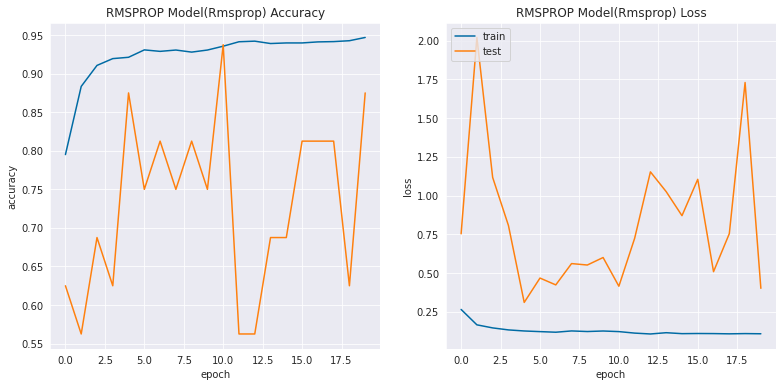

In [ ]:
plot_model(history_rmsprop, 'RMSPROP')

SGD CNN

In [ ]:
def cnn_model_sgd(): # this will be the general CNN structure
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    
    opt = SGD(lr=0.001, momentum=0.0, nesterov=False)
    
    model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    
    return model

In [ ]:
filepath = 'cnn_sgd.best.weight.hdf5' # create checkpoint and callback to save best CNN weights 
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=2, 
                              save_best_only=True, 
                              mode='min')
callbacks_list_sgd = [checkpoint]

In [ ]:

model = cnn_model_sgd()

history_sgd = model.fit_generator(train_batches, class_weight={0:1.0, 1:0.4},
                                  steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=valid_batches,
                                  validation_steps=nb_validation_samples // batch_size, 
                                  callbacks=callbacks_list_sgd, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/20
326/326 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.6396
Epoch 1: val_loss did not improve from 0.52301
326/326 [==============================] - 76s 233ms/step - loss: 0.3837 - accuracy: 0.6396 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/20
326/326 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.7285
Epoch 2: val_loss did not improve from 0.52301
326/326 [==============================] - 72s 222ms/step - loss: 0.3818 - accuracy: 0.7285 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 3/20
326/326 [==============================] - ETA: 0s - loss: 0.3808 - accuracy: 0.7335
Epoch 3: val_loss did not improve from 0.52301
326/326 [==============================] - 75s 230ms/step - loss: 0.3808 - accuracy: 0.7335 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 4/20
326/326 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.7487
Epoch 4: val_loss did not improve from 0.52301
326/326 [=================

In [ ]:
model.save('sgd_xray.h5')  # creates a HDF5 file 

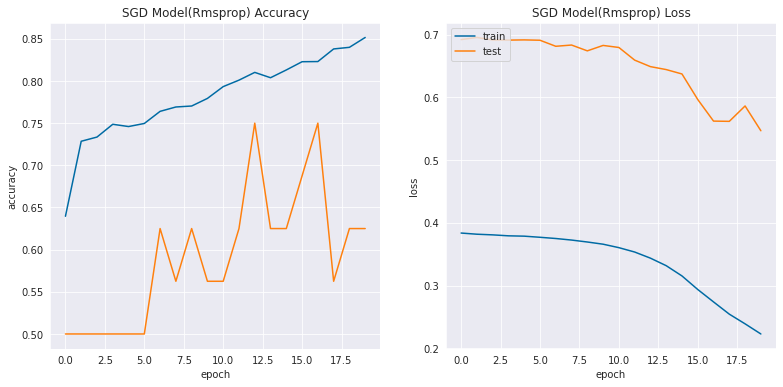

In [ ]:
plot_model(history_sgd, 'SGD')

ADAM CNN

In [ ]:
def cnn_model_adam(): # this will be the general CNN structure
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    return model

In [ ]:
filepath = 'cnn_adam.best.weight.hdf5' # create checkpoint and callback to save best CNN weights 
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=2, 
                              save_best_only=True, 
                              mode='min')
callbacks_list_adam = [checkpoint]

In [ ]:
model = cnn_model_adam()

history_adam = model.fit_generator(train_batches, class_weight={0:1.0, 1:0.4},
                                  steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=valid_batches,
                                  validation_steps=nb_validation_samples // batch_size, 
                                  callbacks=callbacks_list_adam, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/20
326/326 [==============================] - ETA: 0s - loss: 0.2804 - accuracy: 0.7673
Epoch 1: val_loss did not improve from 0.31642
326/326 [==============================] - 121s 230ms/step - loss: 0.2804 - accuracy: 0.7673 - val_loss: 0.5411 - val_accuracy: 0.8125
Epoch 2/20
326/326 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.8533
Epoch 2: val_loss did not improve from 0.31642
326/326 [==============================] - 76s 234ms/step - loss: 0.1982 - accuracy: 0.8533 - val_loss: 0.6178 - val_accuracy: 0.7500
Epoch 3/20
326/326 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.8821
Epoch 3: val_loss did not improve from 0.31642
326/326 [==============================] - 74s 227ms/step - loss: 0.1733 - accuracy: 0.8821 - val_loss: 1.1967 - val_accuracy: 0.6875
Epoch 4/20
326/326 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.8867
Epoch 4: val_loss did not improve from 0.31642
326/326 [================

In [ ]:
model.save('adam_xray.h5')  # creates a HDF5 file 

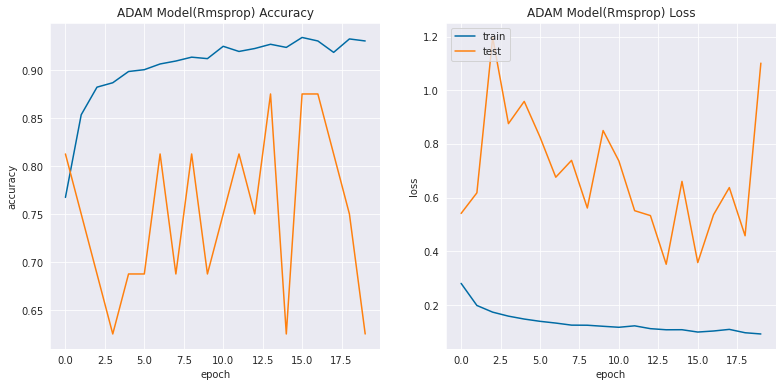

In [ ]:
plot_model(history_adam, 'ADAM')

In [ ]:
sgd_history = load_model('sgd_xray.h5') # load saved CNN weights 

adam_history = load_model('adam_xray.h5')

rmsprop_history = load_model('rmsprop_xray.h5')

In [ ]:
print('TRAINING SET ACCURACY SCORES')

scores_adam_train = adam_history.evaluate_generator(train_batches)
print("\nADAM %s: %.2f%%" % (adam_history.metrics_names[1], scores_adam_train[1]*100))

scores_sgd_train = sgd_history.evaluate_generator(train_batches)
print("\nSGD %s: %.2f%%" % (sgd_history.metrics_names[1], scores_sgd_train[1]*100))

scores_rmsprop_train = rmsprop_history.evaluate_generator(train_batches)
print("\nRMSPROP %s: %.2f%%" % (rmsprop_history.metrics_names[1], scores_rmsprop_train[1]*100))

TRAINING SET ACCURACY SCORES


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.




ADAM accuracy: 95.61%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.




SGD accuracy: 87.38%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.




RMSPROP accuracy: 95.46%


In [ ]:
print('TESTING SET ACCURACY SCORES')

scores_adam = adam_history.evaluate_generator(test_batches)
print("\nADAM %s: %.2f%%" % (adam_history.metrics_names[1], scores_adam[1]*100))

scores_sgd = sgd_history.evaluate_generator(test_batches)
print("\nSGD %s: %.2f%%" % (sgd_history.metrics_names[1], scores_sgd[1]*100))

scores_rmsprop = rmsprop_history.evaluate_generator(test_batches)
print("\nRMSPROP %s: %.2f%%" % (rmsprop_history.metrics_names[1], scores_rmsprop[1]*100))

TESTING SET ACCURACY SCORES


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.




ADAM accuracy: 91.35%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.




SGD accuracy: 83.33%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.




RMSPROP accuracy: 91.35%


In [ ]:
print('TRAINING SET LOSS SCORES')

train_loss_adam, train_score_adam = adam_history.evaluate_generator(train_batches)
print("\nADAM loss: ", train_loss_adam)

train_loss_sgd, train_score_sgd = sgd_history.evaluate_generator(train_batches)
print("\nSGD loss: ", train_loss_sgd)

train_loss_rsmprop, train_score_rsmprop = rmsprop_history.evaluate_generator(train_batches)
print("\nRMSPROP loss: ", train_loss_rsmprop)

TRAINING SET LOSS SCORES


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.




ADAM loss:  0.1142803281545639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.




SGD loss:  0.33250686526298523


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.




RMSPROP loss:  0.1148180365562439


In [ ]:
print('TESTING SET LOSS SCORES')

test_loss_adam, test_score_adam = adam_history.evaluate_generator(test_batches)
print("\nADAM loss: ", test_loss_adam)

test_loss_sgd, test_score_sgd = sgd_history.evaluate_generator(test_batches)
print("\nSGD loss: ", test_loss_sgd)

test_loss_rsmprop, test_score_rsmprop = rmsprop_history.evaluate_generator(test_batches)
print("\nRMSPROP loss: ", test_loss_rsmprop)


TESTING SET LOSS SCORES


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.




ADAM loss:  0.409670889377594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.




SGD loss:  0.3909783959388733


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.




RMSPROP loss:  0.409670889377594


In [ ]:
ADAM = {'Train Acc': round(scores_adam_train[1]*100,2), 'Test Acc': round(scores_adam[1]*100,2), 'Train Loss': round(train_loss_adam,2), 'Test Loss': round(test_loss_adam, 2), 'Train/Test Difference': round(scores_adam_train[1]*100-scores_adam[1]*100,2)}
SGD = {'Train Acc': round(scores_sgd_train[1]*100,2), 'Test Acc': round(scores_sgd[1]*100,2), 'Train Loss': round(train_loss_sgd,2), 'Test Loss': round(test_loss_sgd, 2), 'Train/Test Difference':round(scores_sgd_train[1]*100-scores_sgd[1]*100,2)}
RMSPROP = {'Train Acc': round(scores_rmsprop_train[1]*100,2), 'Test Acc': round(scores_rmsprop[1]*100,2), 'Train Loss': round(train_loss_rsmprop,2), 'Test Loss': round(test_loss_rsmprop, 2), 'Train/Test Difference':round(scores_rmsprop_train[1]*100-scores_rmsprop[1]*100,2)}

In [ ]:
df = pd.DataFrame([ADAM, SGD, RMSPROP])
df = df.rename({0: 'ADAM', 1: 'SGD', 2: 'RMSPROP'})
df

,Train Acc,Test Acc,Train Loss,Test Loss,Train/Test Difference
ADAM,95.61,91.35,0.11,0.41,4.26
SGD,87.38,83.33,0.33,0.39,4.05
RMSPROP,95.46,91.35,0.11,0.41,4.11


In [ ]:
import subprocess

df.to_html('FC_metrics_df.html') # save metrics dataframe
subprocess.call(
    'wkhtmltoimage -f png --width 0 FC_metrics_df.html FC_metrics_df.png', shell=True)

127

In [ ]:
CATEGORIES = ["NORMAL", "PNEUMONIA"]

def create_data(directory,data):
    for category in CATEGORIES:  # do normal and pneumonia

        path = os.path.join(directory,category)  # create path to normal and pneumonia
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=normal 1=pneumonia

        for img in tqdm(os.listdir(path)):  # iterate over each image per normal and pneumonia
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                
                data.append([img_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

In [ ]:
test_data = [] 

create_data(test_data_dir,test_data)

print("Test Data Instances: {}".format(len(test_data)))

100%|██████████| 390/390 [00:05<00:00, 69.35it/s]

Test Data Instances: 624


In [ ]:
y_test = [] # testing label dataset for prediction purposes  

for features,label in test_data:
    y_test.append(label)

In [ ]:
p_rmsprop = rmsprop_history.predict(test_batches) 
preds_rmsprop = np.argmax(p_rmsprop, axis=-1)
print(preds_rmsprop.shape)

p_adam = adam_history.predict(test_batches)
preds_adam = np.argmax(p_adam, axis=-1)
print(preds_adam.shape)

p_sgd = sgd_history.predict(test_batches)
preds_sgd = np.argmax(p_sgd, axis=-1)
print(preds_sgd.shape)

(624,)
(624,)
(624,)


In [ ]:
print('ADAM CNN MODEL')
print(classification_report(y_test, preds_adam))

ADAM CNN MODEL
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       234
           1       0.90      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624



In [ ]:
print('SGD CNN MODEL')
print(classification_report(y_test, preds_sgd))

SGD CNN MODEL
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       234
           1       0.88      0.85      0.86       390

    accuracy                           0.83       624
   macro avg       0.82      0.83      0.82       624
weighted avg       0.84      0.83      0.83       624



In [ ]:
print('RMSPROP CNN MODEL')
print(classification_report(y_test, preds_rmsprop))

RMSPROP CNN MODEL
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       234
           1       0.90      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624



In [ ]:
ADAM_2 = {'Recall': .90, 'Precision': .90, 'F1-score': .90}
SGD_2 = {'Recall': .84, 'Precision': .84, 'F1-score': .84}
RMSPROP_2 = {'Recall': .91, 'Precision': .90, 'F1-score': .90}

In [ ]:
class_df = pd.DataFrame([ADAM_2, SGD_2, RMSPROP_2])
class_df = class_df.rename({0: 'ADAM', 1: 'SGD', 2: 'RMSPROP'})
class_df

,Recall,Precision,F1-score
ADAM,0.90,0.90,0.90
SGD,0.84,0.84,0.84
RMSPROP,0.91,0.90,0.90


In [ ]:
class_df.to_html('FC_class_df.html') #save report dataframe 
subprocess.call(
    'wkhtmltoimage -f png --width 0 FC_class_df.html FC_class_df.png', shell=True)

127

In [ ]:
def plot_combined_model(model_history1,model_history2,model_history3):
    '''
    Simple function to plot the loss and accuracy of the validation data.
    '''
    sns.set_style("darkgrid")
    plt.style.use('tableau-colorblind10')
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
    
    ax1.plot(model_history1.history['accuracy'])
    ax1.plot(model_history2.history['accuracy'])
    ax1.plot(model_history3.history['accuracy'])
    
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Train Accuracy')
    ax1.set_xlabel('Epoch')
    
    ax2.plot(model_history1.history['loss'])
    ax2.plot(model_history2.history['loss'])
    ax2.plot(model_history3.history['loss'])
    
    ax2.set_title('CNN Model Loss')
    ax2.set_ylabel('Train Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Adam', 'Sgd', 'Rmsprop'], loc='upper right')

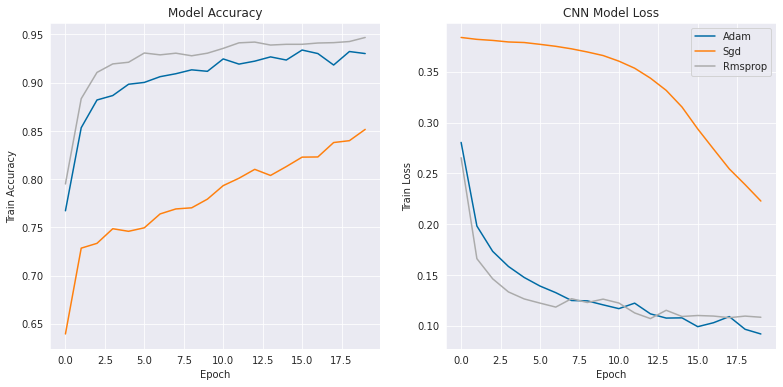

In [ ]:
plot_combined_model(history_adam,history_sgd,history_rmsprop)

In [ ]:
!jupyter nbconvert --to html Task0.ipynb

[NbConvertApp] Converting notebook Task0.ipynb to html
[NbConvertApp] Writing 1692600 bytes to Task0.html


In [ ]:
!pandoc Task0.html -s -o Task0.docx